In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import raw_data_processing
import tensorflow as tf
import pickle
import self_har_models
import numpy as np
import data_pre_processing
import seaborn as sns
tf.get_logger().setLevel('INFO')

In [10]:
with open('pickled_datasets/hhar_HAR.pickle', 'rb') as file:
    hhar_df = pickle.load(file)

In [3]:
full_model = tf.keras.models.load_model('CNN-LSTM')

In [4]:
core_model = self_har_models.extract_core_model(full_model)

In [12]:
print(hhar_df)

{'a': [(array([[-5.958191 ,  0.6880646,  8.135345 ],
       [-5.95224  ,  0.6702118,  8.136536 ],
       [-5.9950867,  0.6535492,  8.204376 ],
       ...,
       [ 7.201669 , -1.838724 ,  7.66135  ],
       [ 7.048442 , -1.53227  ,  7.508123 ],
       [ 6.741988 , -1.53227  ,  7.354896 ]]), array(['stand', 'stand', 'stand', ..., 'bike', 'bike', 'bike'],
      dtype=object))], 'b': [(array([[-1.9020386,  1.7961273, 10.063446 ],
       [-1.9317932,  1.8877716, 10.157471 ],
       [-1.8175354,  1.9532318, 10.202698 ],
       ...,
       [-2.451632 ,  0.       , 10.266209 ],
       [-2.604859 , -0.459681 , 10.419436 ],
       [-2.298405 , -0.612908 , 10.266209 ]]), array(['stand', 'stand', 'stand', ..., 'bike', 'bike', 'bike'],
      dtype=object))], 'c': [(array([[-2.7161255 , -0.893692  ,  9.64212   ],
       [-2.6470947 , -0.925827  ,  9.657593  ],
       [-2.719696  , -0.93296814,  9.674255  ],
       ...,
       [ 5.056491  ,  0.766135  ,  5.822626  ],
       [ 5.822626  ,  0.459681  

In [14]:
def get_labels(data):
    all_labels = []
    for user in data:
        all_labels = np.concatenate((np.unique(data[user][0][1]), all_labels))
    labels = np.unique(all_labels)
    return labels

labels = get_labels(hhar_df)
label_map = {label: index for index, label in enumerate(labels)}
print(label_map)

{'bike': 0, 'sit': 1, 'stairsdown': 2, 'stairsup': 3, 'stand': 4, 'walk': 5}


In [37]:
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
harth_df, label_map, 12,
    ['006', '008', '009', '010', '012', '013' , '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025'],
['026', '027', '028', '029'], 400, 200)

getting mean
[-0.87959782 -0.00604676 -0.14753301]
[0.33156394 0.23069429 0.35753116]
normalising train set
normalisnig test


In [18]:
user_datasets_processed = data_pre_processing.pre_process_dataset_composite(
hhar_df, label_map, 6,
    ['a', 'b', 'c', 'd', 'e', 'f', 'g'],
['h', 'i'], 400, 200)

getting mean
[-1.53514467  0.15958888  8.87110299]
[4.05960663 1.57266006 2.32821487]
normalising train set
normalisnig test


In [19]:
callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [22]:
full_CNNLSTM_model = self_har_models.attach_full_har_classification_head(core_model, 6, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))
CNNLSTM_history = full_CNNLSTM_model.fit(user_datasets_processed[0][0], user_datasets_processed[0][1]
                    , epochs=100, validation_data=(user_datasets_processed[1][0], user_datasets_processed[1][1]), callbacks=[callback])

Epoch 1/100
1089/1089 [==============================] - 16s 12ms/step - loss: 0.2013 - categorical_accuracy: 0.9597 - auc: 0.9954 - precision: 0.9683 - recall: 0.9270 - val_loss: 0.1579 - val_categorical_accuracy: 0.9564 - val_auc: 0.9969 - val_precision: 0.9616 - val_recall: 0.9535
Epoch 2/100
1089/1089 [==============================] - 11s 10ms/step - loss: 0.1228 - categorical_accuracy: 0.9705 - auc: 0.9979 - precision: 0.9750 - recall: 0.9662 - val_loss: 0.1473 - val_categorical_accuracy: 0.9700 - val_auc: 0.9951 - val_precision: 0.9744 - val_recall: 0.9668
Epoch 3/100
1089/1089 [==============================] - 11s 10ms/step - loss: 0.1178 - categorical_accuracy: 0.9712 - auc: 0.9980 - precision: 0.9753 - recall: 0.9666 - val_loss: 0.0867 - val_categorical_accuracy: 0.9811 - val_auc: 0.9992 - val_precision: 0.9834 - val_recall: 0.9801
Epoch 4/100
1089/1089 [==============================] - 11s 10ms/step - loss: 0.1072 - categorical_accuracy: 0.9744 - auc: 0.9984 - precision: 0

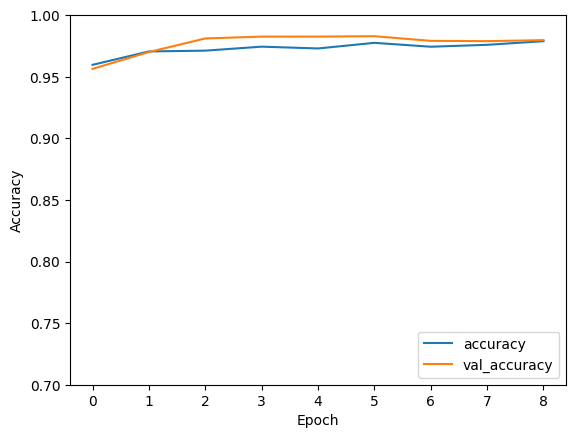

401/401 [==============================] - 2s 4ms/step


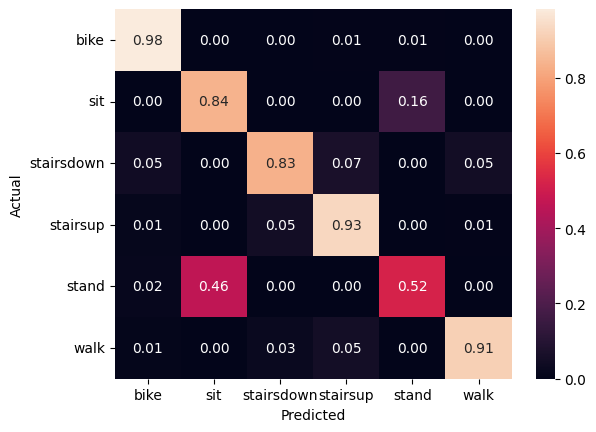

In [23]:
import matplotlib.pyplot as plt
plt.plot(CNNLSTM_history.history['categorical_accuracy'], label='accuracy')
plt.plot(CNNLSTM_history.history['val_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.7, 1])
plt.legend(loc='lower right')
plt.show()

lstm_test_result = full_CNNLSTM_model.evaluate(user_datasets_processed[2][0],  user_datasets_processed[2][1], return_dict=True)
predicted_labels = np.argmax(full_CNNLSTM_model.predict(user_datasets_processed[2][0]), axis=1)
true_labels = np.argmax(user_datasets_processed[2][1], axis=1)
confusion_mat = tf.math.confusion_matrix(true_labels, predicted_labels)
cm = confusion_mat.numpy()
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [25]:
full_CNNLSTM_model